In [1]:
import tabula
import os
import matplotlib.pyplot as plt
from ipywidgets import interact
import warnings
from tabula.io import read_pdf
warnings.simplefilter(action='ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#from wordcloud import WordCloud

In [2]:
import pandas as pd
# create an empty dataframe that will collect all the data
df  = pd.DataFrame()
for i in os.listdir("transactions"):
    
    if ".pdf" in i:
        try:
            print(i)
            #create yet another dataframe that will collect all data from each page
            temp = pd.DataFrame()
            data = read_pdf("transactions/" +i, pages='all',password = "29559943",multiple_tables=True)
            print("read...")
            for i in range(1,len(data)):
                temp = pd.concat((data[i],temp),0)
                #print(temp.shape)
            dt = pd.DataFrame(temp)
            df = pd.concat((df,dt),0)
            
            #print(data.head(2))
        except:
            print("cant")
            pass

MPESA_Statement1.pdf
read...
MPESA_Statement2.pdf
read...
MPESA_Statement3.pdf
read...
MPESA_Statement4.pdf
read...
MPESA_Statement5.pdf
read...
MPESA_Statement6.pdf
read...
MPESA_Statement7.pdf
read...


In [3]:
# clean the df

df["Completion Time"] = pd.DatetimeIndex(df["Completion Time"])
df["Month"]= [i.month_name() for i in df["Completion Time"]]


In [4]:
import sqlite3
conn = sqlite3.connect("Mpesa1.db")
# send the data to the database so I wont have to keep on reading the pdfs
df.to_sql("Mpesa",conn,if_exists='replace')
df.head()

,Receipt No.,Completion Time,Details,Transaction\rStatus,Paid In,Withdrawn,Balance,Unnamed: 0,Transaction,Month
0,PH50977OKS,2021-08-05 20:22:02,Customer Transfer to 254729164543 - CHERUTICH\...,Completed,NaN,-500.00,"4,500.61",NaN,NaN,August
1,PH549688WQ,2021-08-05 20:08:16,Business Payment from 501901 - KCB 1 via API. ...,Completed,"5,000.00",NaN,"5,000.61",NaN,NaN,August
2,PH508AJCWY,2021-08-05 11:25:11,Withdrawal Charge,Completed,NaN,-27.00,0.61,NaN,NaN,August
3,PH508AJCWY,2021-08-05 11:25:11,Customer Withdrawal At Agent Till 2000342 - S...,Completed,NaN,-450.00,27.61,NaN,NaN,August
4,PH58896SDY,2021-08-05 10:58:13,Airtime Purchase,Completed,NaN,-20.00,477.61,NaN,NaN,August


# Airtime analysis

In [5]:
def cleaner(lis):
    clean = []
    for i in lis:
        try:
            x = i.replace("-","").replace(",","")
            clean.append(float(x))
        except:
            clean.append(np.nan)
    return clean

class MpesaAnalyzer:
    def __init__(self,conn,data =None):
        self.conn = conn
        self.data = data
    
    def Airtime(self):
        data = pd.read_sql("""select Month,-1*SUM(Withdrawn)
        from Mpesa 
        where Details like '%airtime%' 
        group by month 
        order by Month""",self.conn)
        data.columns = ["x","y"]
        self.data = data
       # data['x'] = pd.Categorical(data['x'],categories =['January',  'February','March',  'April','May','June',July',  'August', 'September','October', 'November','December'] ,ordered =True)
        data['x'] = pd.Categorical(data['x'],categories =['July',  'August', 'September','October', 'November','December','January'],
                                   ordered =True)
        
        plt.figure(figsize = (15,7))
        graph = sns.barplot(data = data,x = "x",y = "y")
        for p in graph.patches:
            graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                        ha='center', va='bottom',
                        color= 'black')
        plt.title("Mpesa Airtime plot")
        return plt.show()
    
    def Charges(self):
        data = pd.read_sql("""select Month,-1*sum(Withdrawn) from Mpesa where Details like '%charge%' group by month order by Month """,self.conn)
        data.columns = ["x","y"]
        self.data = data
        data['x'] = pd.Categorical(data['x'],categories =['January',  'February','March',  'April','May','June', 'July',  'August', 'September','October', 'November','December'] ,ordered =True)
        plt.figure(figsize = (15,7))
        graph = sns.barplot(data = data,x = "x",y = "y")
        for p in graph.patches:
            graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                        ha='center', va='bottom',
                        color= 'black')
        plt.title("Mpesa Charges plot")
        return plt.show()
    
    def Number_analysis(self,name,title = ""):
        name = "254" + name[len(name)-9:len(name)]
        data = pd.read_sql("""select  * from Mpesa where Details like '%{}%'  """.format(name),conn)
        data = data[["Month","Withdrawn","Paid In"]]
        data['Withdrawn'] = cleaner(data['Withdrawn'])
        data['Paid In'] = cleaner(data['Paid In'])
        data = data.groupby("Month").agg(["sum"]).reset_index()
        data.columns = ["Month","Withdrawn","Paid In"]
        self.data = data
        data["Month"] = pd.Categorical(data["Month"],categories =['January',  'February','March',  'April','May','June', 'July',  'August', 'September','October', 'November','December'] ,ordered =True)
        data1 = data.pivot_table(index='Month',
               margins=True,
               margins_name='total',  # defaults to 'All'
               aggfunc=sum)
        data_melt = data.melt(id_vars = "Month")
        plt.figure(figsize = (15,7))
        graph = sns.barplot(data = data_melt,x = "Month",y = "value",hue = "variable")
        plt.title(title)
        for p in graph.patches:
            graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                        ha='center', va='bottom',
                        color= 'black')
        
        return plt.show(),print(data1)
    def general_analyzer(self,keyword):
        name = keyword
        data = pd.read_sql("""select  * from Mpesa where Details like '%{}%'  """.format(name),conn)
        data = data[["Month","Withdrawn","Paid In"]]
        data['Withdrawn'] = cleaner(data['Withdrawn'])
        data['Paid In'] = cleaner(data['Paid In'])
        data = data.groupby("Month").agg(["sum"]).reset_index()
        data.columns = ["Month","Withdrawn","Paid In"]
        self.data = data
        data["Month"] = pd.Categorical(data["Month"],categories =['January',  'February','March',  'April','May','June', 'July',  'August', 'September','October', 'November','December'] ,ordered =True)
        
        data_melt = data.melt(id_vars = "Month")
        plt.figure(figsize = (15,7))
        graph = sns.barplot(data = data_melt,x = "Month",y = "value",hue = "variable")
        for p in graph.patches:
            graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                        ha='center', va='bottom',
                        color= 'black')

        return plt.show()
    def Frequent(self,number = 10):
        data = pd.read_sql("""select  * from Mpesa """,conn)
        names = []
        for i in data['Details']:
            try:
                x = i.split("-")[1].replace("\r"," ")\
                .replace("  ","")
                names.append("_".join(x.split()[:3]))
            except:
                names.append("") 
        data['people'] = names
        test1 = data.people.value_counts()
        dt = pd.DataFrame(test1)
        dt = dt[dt['people']!=" "]
        dt.columns = ["Accounts_frequently_transacted_with"]
        plt.figure(figsize = (10,10))
        word_cloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(names))
        plt.imshow(word_cloud, interpolation='bilinear')
        plt.axis("off")
        
        
        return (plt.show(),dt.head(number).iloc[1:number,:])
        
        
        
        
        
        
        


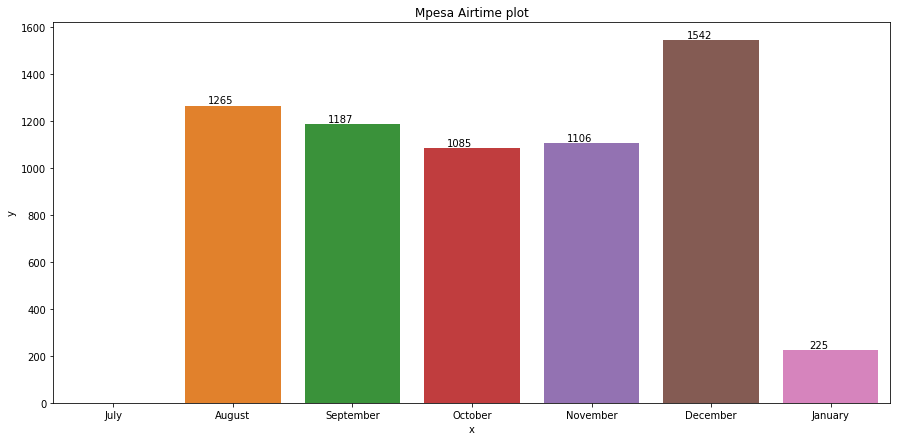

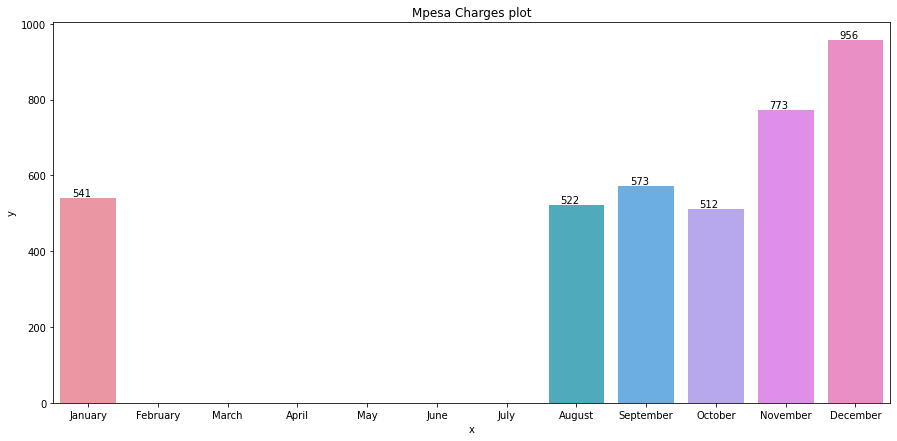

ValueError: min() arg is an empty sequence

<Figure size 1080x504 with 0 Axes>

In [6]:
analysis = MpesaAnalyzer(conn)
analysis.Airtime()
analysis.Charges()
analysis.Number_analysis("0704072220",title= "Cosmas transaction")
analysis.general_analyzer("selfridges")
analysis.Frequent()
analysis.data

In [15]:
#analysis.general_analyzer("internet")

ValueError: min() arg is an empty sequence

<Figure size 1080x504 with 0 Axes>

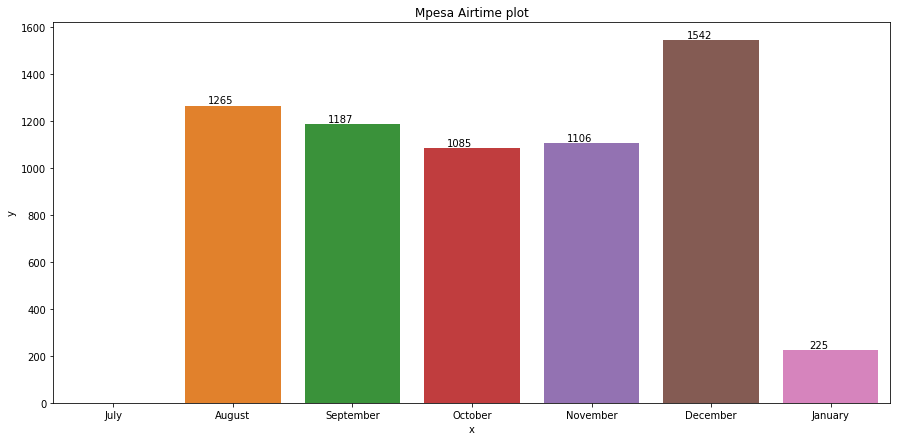

In [7]:
analysis.Airtime()

In [8]:
analysis.data

,x,y
0,August,1265.0
1,December,1542.0
2,January,225.0
3,November,1106.0
4,October,1085.0
5,September,1187.0


In [9]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from string import punctuation
x = []
for i in data.Details:
    for j in nltk.word_tokenize(str(i)):
        x.append(j)
from nltk.corpus import stopwords
stoplist = stopwords.words('english') + ['though']+list(punctuation)
x = [i.lower() for i in x if not i in stoplist ]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cosmas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cosmas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


AttributeError: 'list' object has no attribute 'Details'

In [ ]:
freq = nltk.FreqDist(x)
import matplotlib.pyplot as plt

plt.figure(figsize = (20,7))
freq.plot(40)
plt.show()

In [ ]:
names

In [ ]:
text = "haha i am big"


In [143]:
word_cloud